## Pre Processing

In [ ]:
import numpy as np
import pandas as pd

In [2]:
## Original Data

data = pd.read_csv('../Data/Processed Dataset/original_data_preprocessed.csv')
data=data.drop(['Date','Time','TimeStamp'],axis=1)
X=data.iloc[:,1:]
Y=data['solar_output']

mean=X.mean(axis=0)
std=X.std(axis=0)
X=(X-mean)/std
X.head()

,temperature,humidity,wind_speed,visibility,serial,month,Day
0,0.470858,1.605282,-1.460675,0.193227,-1.663916,0.756522,-1.669266
1,0.470858,1.605282,-1.087293,0.193227,-1.525256,0.756522,-1.669266
2,0.470858,1.605282,-1.460675,0.193227,-1.386596,0.756522,-1.669266
3,0.622494,1.429772,-0.006451,0.193227,-1.247937,0.756522,-1.669266
4,0.622494,1.429772,0.366930,0.193227,-1.109277,0.756522,-1.669266


In [5]:
## Interpolated Data

data1 = pd.read_csv('../Data/Processed Dataset/original_data_preprocessed.csv')
data1=data1.drop(['Date','Time','TimeStamp'],axis=1)
X1=data1.iloc[:,2:]
Y1=data1['solar_output']

mean=X1.mean(axis=0)
std=X1.std(axis=0)
X1=(X1-mean)/std
X1.tail()

,humidity,wind_speed,visibility,serial,month,Day
4495,-1.378388,1.094042,1.595344,1.109277,-0.773522,1.662883
4496,-1.378388,0.856257,1.595344,1.247937,-0.773522,1.662883
4497,-1.378388,0.720660,1.595344,1.386596,-0.773522,1.662883
4498,-1.466143,0.720660,0.193227,1.525256,-0.773522,1.662883
4499,-1.378388,0.366930,1.595344,1.663916,-0.773522,1.662883


In [90]:
#X_test=X[23057:26101]
#Y_test=Y[23057:26101]
#X=X[:23057]
#Y=Y[:23057]
#X_test.head()


### Keras

In [91]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

print(tf.__version__)

1.9.0


In [159]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_target = train_test_split(X1, Y1, test_size=0.2,random_state=40)

In [160]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),



    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()
#path='saves/19/'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 128)               1024      
_________________________________________________________________
dense_194 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_195 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_196 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 129       
Total params: 50,689
Trainable params: 50,689
Non-trainable params: 0
_________________________________________________________________


In [161]:
#### Display training progress by printing a single dot for each completed epoch
EPOCHS = 500
%matplotlib inline
import matplotlib.pyplot as plt

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  #plt.savefig(path+'#1')
  plt.ylim([0, 10])


In [162]:
k=5
num_val_samples=len(train_data)//k
all_scores=[]
for i in range(k):
    print('Processing Fold #',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_target=np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0)
    model = build_model()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    model.fit(partial_train_data, partial_train_target, epochs=500,
                    verbose=0,
                    callbacks=[PrintDot()])
    
    val_mse,val_mae=model.evaluate(val_data,val_targets)
    
    all_scores.append(val_mae)
    
print(np.mean(all_scores))

Processing Fold # 0

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
4176/4176 [==============================] - 1s 132us/step...................................
Processing Fold # 1

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
4176/4176 [==============================] - 1s 132us/st

### RUN BELOW FOR WITHOUT K-FOLD CROSS-VALIDATION


........................................................................................

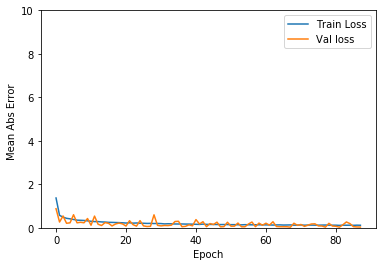

In [139]:


## Early Stopping ##
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data,train_targets, epochs=500,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [154]:
[loss, mae] = model.evaluate(test_data, test_target, verbose=0)

print("Mean Absolute Error on the Testing set: {:7.2f}".format(mae*1000))

ValueError: Error when checking input: expected dense_188_input to have shape (8,) but got array with shape (7,)

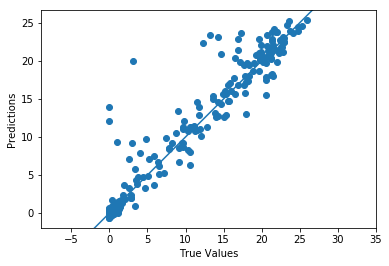

In [29]:
## Plotting the Graph 

test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test[400:600],test_predictions[400:600])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())

_ = plt.plot([-100, 100], [-100, 100])
#plt.savefig(path+'#2')

In [30]:
len(history.history['loss'])

Using TensorFlow backend.


In [ ]:
from keras.utils import plot_model

plot_model(model, to_file=path+'model.png',show_shapes=True)
model.save_weights(path+'my_model_weights.h5')

In [ ]:
df = pd.DataFrame()

test_predictions = model.predict(X1).flatten()
df['prediction']=test_predictions
df.to_csv('prediction_sir.csv')